In [1]:
# objective: generate the particle size structure for the CMIP6 models
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob,os,subprocess
from glob import glob
import IPython.display as display
%matplotlib inline
from datetime import datetime as dt
import matplotlib.gridspec as gridspec
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.stats as st

## Mean historical by biome and model

In [2]:
palette_source = dict(CESM= '#0077BB',CMCC= '#33BBEE', CNRM= '#009988',GFDL= '#EE7733', GISS= '#CC3311', IPSL= '#EE3377',UKESM= '#BBBBBB', PSSdb = 'black')
palette_experiments= dict(hist='rosybrown', ssp5='firebrick', obs='blue')
line_style = ['--','--','--','--','--','-','--']

letters_clim = ['e.','f.','g.',  'h.','i.','j.',  'k.','l.','m.']

In [3]:
df_CMIP6=pd.read_csv('/work/m1c/CMIP6_biome_PSS_data/CMIP6_data_full_biovolume.csv', sep= ',') # remove all winter data points and do an annual mean


#df_CMIP6 = df_CMIP6.loc[df_CMIP6.source != 'GISS'].reset_index(drop=True)
#df_CMIP6 = df_CMIP6.loc[df_CMIP6.source != 'CESM'].reset_index(drop=True)

df_CMIP6=df_CMIP6.drop(columns=['season'])
df_CMIP6


,lat,lon,month,biomes,slope,intercept,R2,total_biovolume,experiment,source
0,-77.5,-179.5,1.0,HCSS,-0.907265,1.448721e+11,0.976717,3.604478e+12,hist,CESM
1,-77.5,-178.5,1.0,HCSS,-0.909153,1.584194e+11,0.976510,3.791176e+12,hist,CESM
2,-77.5,-177.5,1.0,HCSS,-0.911068,1.739923e+11,0.976300,3.999223e+12,hist,CESM
3,-77.5,-176.5,1.0,HCSS,-0.912826,1.916664e+11,0.976097,4.241474e+12,hist,CESM
4,-77.5,-175.5,1.0,HCSS,-0.914441,2.114271e+11,0.975898,4.516142e+12,hist,CESM
...,...,...,...,...,...,...,...,...,...,...
4385478,77.5,177.5,12.0,HCSS,-1.151904,7.503153e+12,0.985942,3.081296e+12,ssp5,UKESM
4385479,77.5,178.5,12.0,HCSS,-1.152228,7.533209e+12,0.985924,3.073716e+12,ssp5,UKESM
4385480,77.5,179.5,12.0,HCSS,-1.152508,7.562250e+12,0.985905,3.068633e+12,ssp5,UKESM
4385481,78.5,-165.5,12.0,HCSS,-1.152636,7.479914e+12,0.985736,2.990052e+12,ssp5,UKESM


In [4]:
test=df_CMIP6[df_CMIP6['lat'].isna()]
test.head()

,lat,lon,month,biomes,slope,intercept,R2,total_biovolume,experiment,source


In [5]:
df_PSSdb = pd.read_csv('/work/m1c/CMIP6_biome_PSS_data/PSSdb_data_full.csv', sep= ',')
df_PSSdb=df_PSSdb.drop(columns=['season'])
df_PSSdb['intercept'] =10**(df_PSSdb['intercept'])
df_PSSdb.head()

,lat,lon,biomes,month,slope,intercept,R2,total_biovolume,experiment,source
0,80.5,69.5,HCSS,8.0,-0.711575,3.424677e+10,0.947649,4.722871e+10,obs,PSSdb
1,79.5,60.5,HCSS,8.0,-1.013523,3.875319e+13,0.966109,8.472178e+11,obs,PSSdb
2,79.5,66.5,HCSS,7.0,-0.727859,1.123122e+11,0.865061,3.418501e+12,obs,PSSdb
3,79.5,69.5,HCSS,8.0,-0.829441,1.757431e+12,0.983299,8.727823e+11,obs,PSSdb
4,79.5,71.5,HCSS,7.0,-0.684871,7.795448e+10,0.950746,1.007926e+12,obs,PSSdb


In [6]:
# remove data from winter in the HCSS since it has very few data points, however, this might need to be discussed. what is the criteria to discard months with low sample size
#df_CMIP6= df_CMIP6.drop(df_CMIP6[(df_CMIP6.biomes=='HCSS')& (df_CMIP6.month==1.0) |(df_CMIP6.month==2.0) |(df_CMIP6.month==12.0)].index).reset_index()
#df_CMIP6

In [7]:
df_CMIP6 = df_CMIP6.astype(dict(zip(['experiment', 'biomes', 'source'],[str]*3))).groupby(['experiment', 'biomes', 'source']).apply(lambda x: pd.Series({

                                                                    'slope':np.nanmean(x.slope),
                                                                    'intercept':np.nanmean(x.intercept),
                                                                    'R2':np.nanmean(x.R2),
                                                                    'total_biovolume':np.nanmean(x.total_biovolume)})).reset_index()

In [8]:
df_CMIP6.slope.mean()

-1.2572106934051643

In [9]:
df_CMIP6 = pd.concat([df_CMIP6, df_PSSdb]).reset_index(drop=True)
df_CMIP6['biovol_log']=np.log10(df_CMIP6.total_biovolume)
df_CMIP6['intercept_log']=np.log10(df_CMIP6.intercept)
df_CMIP6

,experiment,biomes,source,slope,intercept,R2,total_biovolume,lat,lon,month,biovol_log,intercept_log
0,hist,HCPS,CESM,-1.040937,2.263788e+13,0.966072,3.609851e+13,NaN,NaN,NaN,13.557489,13.354836
1,hist,HCPS,CMCC,-1.136895,5.237021e+13,0.988781,1.044925e+14,NaN,NaN,NaN,14.019085,13.719084
2,hist,HCPS,CNRM,-1.234130,4.393350e+14,0.933185,4.343088e+13,NaN,NaN,NaN,13.637799,14.642796
3,hist,HCPS,GFDL,-1.148410,1.299944e+15,0.987464,5.173515e+14,NaN,NaN,NaN,14.713786,15.113925
4,hist,HCPS,GISS,-1.636217,5.451693e+17,0.951595,3.069209e+13,NaN,NaN,NaN,13.487027,17.736531
...,...,...,...,...,...,...,...,...,...,...,...,...
1254,obs,HCSS,PSSdb,-0.581804,3.923129e+09,0.903101,5.871333e+09,-57.5,-67.5,7.0,9.768737,9.593633
1255,obs,HCSS,PSSdb,-1.014763,2.437577e+13,0.943349,1.310059e+12,-60.5,-60.5,7.0,12.117291,13.386958
1256,obs,HCSS,PSSdb,-0.643737,7.762143e+07,0.979019,1.951527e+11,-62.5,-49.5,7.0,11.290374,7.889982
1257,obs,HCSS,PSSdb,-0.728118,2.134133e+11,0.945405,4.007348e+11,-64.5,-53.5,7.0,11.602857,11.329221


In [10]:
df_CMIP6 = df_CMIP6.astype(dict(zip(['experiment', 'biomes', 'source'],[str]*3)))
df_CMIP6.dtypes

experiment          object
biomes              object
source              object
slope              float64
intercept          float64
R2                 float64
total_biovolume    float64
lat                float64
lon                float64
month              float64
biovol_log         float64
intercept_log      float64
dtype: object

In [11]:
df_mean = df_CMIP6.astype(dict(zip(['source', 'experiment', 'biomes'],[str]*3))).groupby(['source', 'experiment', 'biomes']).apply(lambda x: pd.Series({

                                                                    'slope':np.nanmean(x.slope),
                                                                    'intercept':np.nanmean(x.intercept_log),
                                                                    'R2':np.nanmean(x.R2),
                                                                    'total_biovolume':np.nanmean(x.biovol_log)})).reset_index()
df_mean['intercept'] =10**(df_mean['intercept'])#10**(df_mean['intercept'])
df_mean['total_biovolume'] =10**(df_mean['total_biovolume'])
df_mean

,source,experiment,biomes,slope,intercept,R2,total_biovolume
0,CESM,hist,HCPS,-1.040937,2.263788e+13,0.966072,3.609851e+13
1,CESM,hist,HCSS,-1.013324,2.191573e+13,0.945141,3.556125e+13
2,CESM,hist,LC,-1.076459,2.483086e+13,0.991016,3.229765e+13
3,CESM,ssp5,HCPS,-1.023174,2.080413e+13,0.953746,3.379639e+13
4,CESM,ssp5,HCSS,-0.997429,2.062107e+13,0.945136,3.101715e+13
5,CESM,ssp5,LC,-1.074916,2.314234e+13,0.989363,2.994809e+13
6,CMCC,hist,HCPS,-1.136895,5.237021e+13,0.988781,1.044925e+14
7,CMCC,hist,HCSS,-1.126384,5.284514e+13,0.982707,1.696698e+14
8,CMCC,hist,LC,-1.164740,3.960666e+13,0.992117,4.236317e+13
9,CMCC,ssp5,HCPS,-1.135376,5.058032e+13,0.989044,1.018340e+14


In [12]:
df_mean.to_csv('/work/m1c/CMIP6_biome_PSS_data/size_spectra_mean_by_biome.csv', sep= ',', index = False)

In [13]:
#remove GISS 
df_mean=df_mean.loc[df_mean.source != 'GISS'].reset_index(drop=True)
df_mean

,source,experiment,biomes,slope,intercept,R2,total_biovolume
0,CESM,hist,HCPS,-1.040937,2.263788e+13,0.966072,3.609851e+13
1,CESM,hist,HCSS,-1.013324,2.191573e+13,0.945141,3.556125e+13
2,CESM,hist,LC,-1.076459,2.483086e+13,0.991016,3.229765e+13
3,CESM,ssp5,HCPS,-1.023174,2.080413e+13,0.953746,3.379639e+13
4,CESM,ssp5,HCSS,-0.997429,2.062107e+13,0.945136,3.101715e+13
5,CESM,ssp5,LC,-1.074916,2.314234e+13,0.989363,2.994809e+13
6,CMCC,hist,HCPS,-1.136895,5.237021e+13,0.988781,1.044925e+14
7,CMCC,hist,HCSS,-1.126384,5.284514e+13,0.982707,1.696698e+14
8,CMCC,hist,LC,-1.164740,3.960666e+13,0.992117,4.236317e+13
9,CMCC,ssp5,HCPS,-1.135376,5.058032e+13,0.989044,1.018340e+14


In [14]:
#subsets of data
df_mean_ssp5 = df_mean.loc[(df_mean.experiment != 'hist') & (df_mean.source != 'PSSdb')].reset_index(drop=True)
df_mean_hist = df_mean.loc[(df_mean.experiment != 'ssp5')& (df_mean.source != 'PSSdb')].reset_index(drop=True)

In [15]:
df_mean_hist

,source,experiment,biomes,slope,intercept,R2,total_biovolume
0,CESM,hist,HCPS,-1.040937,2.263788e+13,0.966072,3.609851e+13
1,CESM,hist,HCSS,-1.013324,2.191573e+13,0.945141,3.556125e+13
2,CESM,hist,LC,-1.076459,2.483086e+13,0.991016,3.229765e+13
3,CMCC,hist,HCPS,-1.136895,5.237021e+13,0.988781,1.044925e+14
4,CMCC,hist,HCSS,-1.126384,5.284514e+13,0.982707,1.696698e+14
5,CMCC,hist,LC,-1.164740,3.960666e+13,0.992117,4.236317e+13
6,CNRM,hist,HCPS,-1.234130,4.393350e+14,0.933185,4.343088e+13
7,CNRM,hist,HCSS,-1.227850,4.513276e+14,0.920825,3.804454e+13
8,CNRM,hist,LC,-1.289658,4.547358e+14,0.950831,1.771282e+13
9,GFDL,hist,HCPS,-1.148410,1.299944e+15,0.987464,5.173515e+14


## Multi model mean for each experiment

In [16]:
df_mean = df_CMIP6.astype(dict(zip(['experiment', 'biomes'],[str]*3))).groupby(['experiment', 'biomes']).apply(lambda x: pd.Series({

                                                                    'slope':np.nanmean(x.slope),
                                                                    'intercept':np.nanmean(x.intercept_log),
                                                                    'R2':np.nanmean(x.R2),
                                                                    'total_biovolume':np.nanmean(x.biovol_log)})).reset_index()
df_mean['intercept'] =10**(df_mean['intercept'])#10**(df_mean['intercept'])
df_mean['total_biovolume'] =10**(df_mean['total_biovolume'])
df_mean

,experiment,biomes,slope,intercept,R2,total_biovolume
0,hist,HCPS,-1.234479,6.097405e+14,0.964544,6.243080e+13
1,hist,HCSS,-1.224551,8.451899e+14,0.954576,6.167321e+13
2,hist,LC,-1.303855,7.482875e+14,0.972414,2.412559e+13
3,obs,HCPS,-1.051798,3.990426e+13,0.970355,7.800634e+10
4,obs,HCSS,-1.015277,1.824270e+13,0.936230,1.685405e+11
5,obs,LC,-1.170599,1.944348e+14,0.964022,3.037644e+10
6,ssp5,HCPS,-1.234902,5.935959e+14,0.963175,5.749725e+13
7,ssp5,HCSS,-1.231774,8.312429e+14,0.955778,5.373507e+13
8,ssp5,LC,-1.313703,7.529660e+14,0.972471,2.127373e+13


## plots with only PSSdb

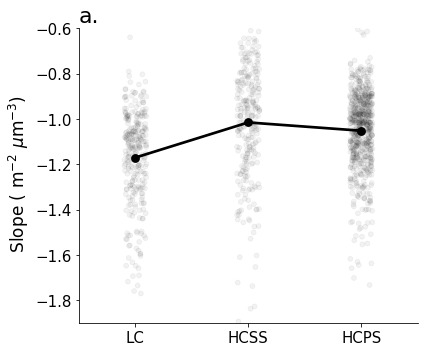

In [17]:
palette_experiments= dict(hist='rosybrown', ssp5='firebrick', obs='black')

#fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
#ax_n = axs

g=sns.catplot( x="biomes", y='slope', hue="experiment", order =['LC', 'HCSS', 'HCPS'],hue_order=[ 'obs'], palette = palette_experiments,  data=df_mean, legend=False, errorbar=None,dodge = 0.5, kind='point')
g.map(sns.stripplot, x='biomes', y='slope', hue='experiment', order =['LC', 'HCSS', 'HCPS'],hue_order=[ 'obs'], alpha=.05, palette = palette_experiments,linewidth=0.7, legend=False,  data=df_CMIP6, dodge=True, edgecolor='black') #hue='source',  palette=palette, hue_order=['hist', 'ssp5', 'obs'],
#sns.lineplot(ax = ax_n, x="biomes", y='slope', hue="experiment", palette = palette_experiments,  data=df_CMIP6, ci=None)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r' Slope ( m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
plt.xlabel('')
plt.ylim(-1.9, -0.6)
plt.title('a.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
#plt.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'observations \n (PSSdb)'], fontsize = 'x-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_slope_avg_PSSdb.pdf', dpi=300)



## intercept

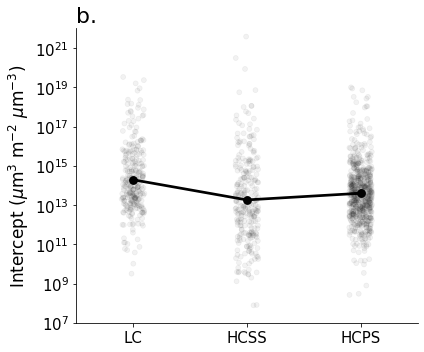

In [18]:

#fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
#ax_n = axs
#sns.pointplot(ax = ax_n, x="biomes", y='intercept_un', hue="experiment", order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5', 'obs'],  palette = palette_experiments,  data=df_mean, errorbar=None, capsize=.1,dodge = 0.5,scale = 1.5)
g=sns.catplot( x="biomes", y='intercept', hue="experiment", order =['LC', 'HCSS', 'HCPS'],hue_order=['obs'], palette = palette_experiments,  data=df_mean, legend=False, errorbar=None,dodge = 0.5, kind='point')
g.map(sns.stripplot, x='biomes', y='intercept', hue='experiment', order =['LC', 'HCSS', 'HCPS'],hue_order=['obs'], alpha=.05, palette = palette_experiments,linewidth=0.7, legend=False,  data=df_CMIP6, dodge=True, edgecolor='black')
#sns.stripplot(ax=ax_n, x='biomes', y='intercept_un', hue='experiment', order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5', 'obs'], alpha=.2, legend=False, palette = palette_experiments,linewidth=0.7,  data=df_CMIP6, dodge=True, edgecolor='black')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r'Intercept ($\mu$m$^{3}$ m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
#ax_n.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'observations \n (PSSdb)'], fontsize = 'xx-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.xlabel('')
plt.ylim(1e7, 1e22)
plt.title('b.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_intercept_avg_PSSdb.pdf', dpi=300)



## biovolume

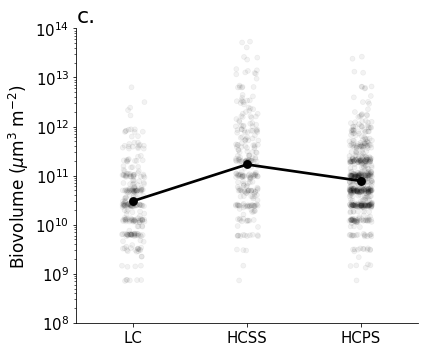

In [19]:

#fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
#ax_n = axs
#sns.pointplot(ax = ax_n, x="biomes", y='total_biovolume', hue="experiment", order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5', 'obs'],  palette = palette_experiments,  data=df_mean, errorbar=None, capsize=.1,dodge = 0.5,scale = 1.5)
#sns.stripplot(ax=ax_n, x='biomes', y='total_biovolume', hue='experiment', order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5', 'obs'], alpha=.2, legend=False, palette = palette_experiments,linewidth=0.7,  data=df_CMIP6, dodge=True, edgecolor='black')
g=sns.catplot( x="biomes", y='total_biovolume', hue="experiment", order =['LC', 'HCSS', 'HCPS'],hue_order=['obs'], palette = palette_experiments,  data=df_mean, legend=False, errorbar=None,dodge = 0.5, kind='point')
g.map(sns.stripplot, x='biomes', y='total_biovolume', hue='experiment', order =['LC', 'HCSS', 'HCPS'],hue_order=['obs'], alpha=.05, palette = palette_experiments,linewidth=0.7, legend=False,  data=df_CMIP6, dodge=True, edgecolor='black')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r'Biovolume ($\mu$m$^{3}$ m$^{-2}$)', fontsize = 17)
plt.ylim(1e8, 1e14)
plt.yscale('log')
plt.xlabel('')
plt.title('c.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
#plt.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'Observations \n (PSSdb)'], fontsize = 'xx-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_total_biovolume_avg_PSSdb.pdf', dpi=300)



## Mean coefficients by biome and model

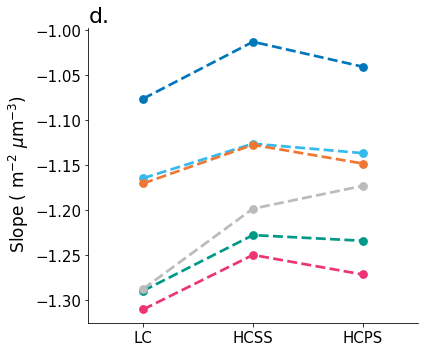

In [20]:
g=sns.catplot( x="biomes", y='slope', hue="source",  order =['LC', 'HCSS', 'HCPS'],  linestyles='--', palette = palette_source,  data=df_mean_hist, legend=False, errorbar=None,dodge = 0, kind='point')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r' Slope ( m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
plt.xlabel('')
#plt.ylim(-1.4, -0.9)
plt.title('d.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
#plt.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'observations \n (PSSdb)'], fontsize = 'x-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_slope_avg_models_NO_GISS_hist.pdf', dpi=300)

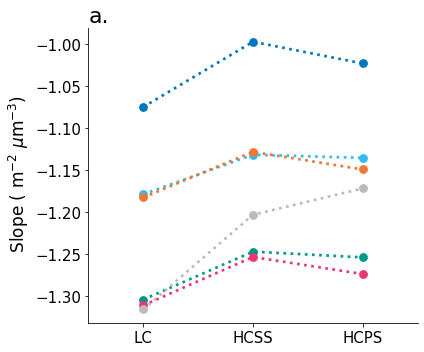

In [21]:
g=sns.catplot( x="biomes", y='slope', hue="source",  order =['LC', 'HCSS', 'HCPS'],  linestyles='dotted', palette = palette_source,  data=df_mean_ssp5, legend=False, errorbar=None,dodge = 0, kind='point')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r' Slope ( m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
plt.xlabel('')
#plt.ylim(-1.4, -0.9)
plt.title('a.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
#plt.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'observations \n (PSSdb)'], fontsize = 'x-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_slope_avg_models_NO_GISS_ssp5.pdf', dpi=300)

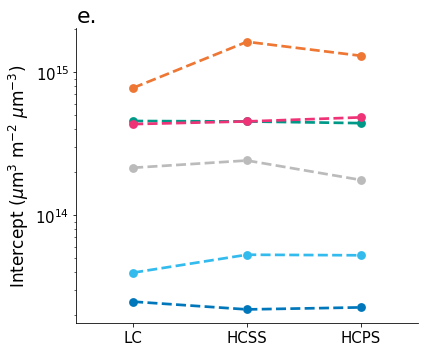

In [22]:
g=sns.catplot( x="biomes", y='intercept', hue="source", order =['LC', 'HCSS', 'HCPS'], linestyles='--', palette = palette_source, data=df_mean_hist, legend=False, errorbar=None,dodge = 0, kind='point')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r'Intercept ($\mu$m$^{3}$ m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
#ax_n.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'observations \n (PSSdb)'], fontsize = 'xx-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.xlabel('')
#plt.ylim(1e7, 1e22)
plt.title('e.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_intercept_avg_models_NO_GISS_hist.pdf', dpi=300)

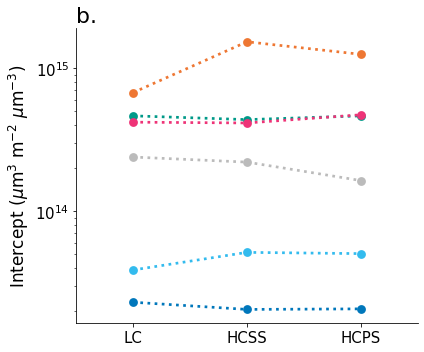

In [23]:
g=sns.catplot( x="biomes", y='intercept', hue="source", order =['LC', 'HCSS', 'HCPS'], linestyles='dotted', palette = palette_source, data=df_mean_ssp5, legend=False, errorbar=None,dodge = 0, kind='point')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r'Intercept ($\mu$m$^{3}$ m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
#ax_n.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'observations \n (PSSdb)'], fontsize = 'xx-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.xlabel('')
#plt.ylim(1e7, 1e22)
plt.title('b.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_intercept_avg_models_NO_GISS_ssp5.pdf', dpi=300)

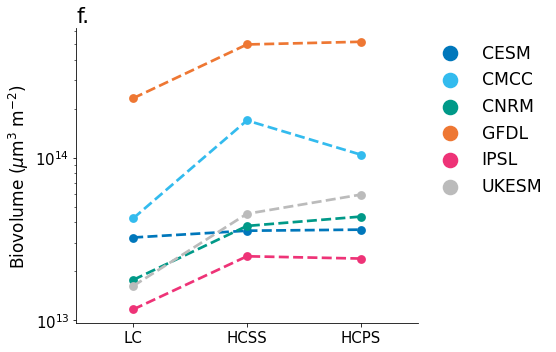

In [24]:
g=sns.catplot( x="biomes", y='total_biovolume', hue="source", order =['LC', 'HCSS', 'HCPS'], linestyles='--', palette = palette_source, data=df_mean_hist, legend=False, errorbar=None,dodge = 0, kind='point')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r'Biovolume ($\mu$m$^{3}$ m$^{-2}$)', fontsize = 17)
#ax_n.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'observations \n (PSSdb)'], fontsize = 'xx-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.xlabel('')
#plt.ylim(1e10, 1e15)
plt.title('f.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels() 
  
# specify order 
#order = [0,1,2,3,4,6,5] #this is if we want to include PSSdb
order = [0,1,2,3,4,5] #without PSSdb
  
# pass handle & labels lists along with order as below 

plt.legend([handles[i] for i in order], [labels[i] for i in order],fontsize = 'xx-large',  markerscale=2, frameon=False, bbox_to_anchor=(1, 1))
plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_biovolume_avg_models_NO_GISS_hist_No_PSSdb.pdf', dpi=300)

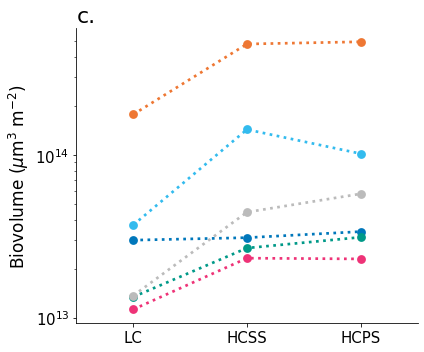

In [25]:
g=sns.catplot( x="biomes", y='total_biovolume', hue="source", order =['LC', 'HCSS', 'HCPS'], linestyles='dotted', palette = palette_source, data=df_mean_ssp5, legend=False, errorbar=None,dodge = 0, kind='point')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r'Biovolume ($\mu$m$^{3}$ m$^{-2}$)', fontsize = 17)
#ax_n.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'observations \n (PSSdb)'], fontsize = 'xx-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.xlabel('')
#plt.ylim(1e13, 1e15)
plt.title('c.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
#handles, labels = plt.gca().get_legend_handles_labels() 

  
# pass handle & labels lists along with order as below 

#plt.legend([handles[i] for i in order], [labels[i] for i in order],fontsize = 'xx-large',  markerscale=2, frameon=False, bbox_to_anchor=(1, 1))
plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_biovolume_avg_models_NO_GISS_ssp5.pdf', dpi=300)

## Multi model mean comparing hist and SSP5

In [30]:
df_mean
df_mean.to_csv('/work/m1c/CMIP6_biome_PSS_data/mean_coeff_by_biome.csv', sep= ',', index = False)

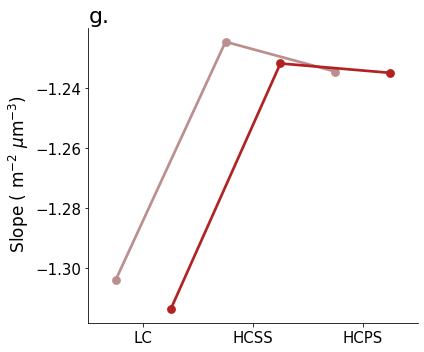

In [27]:
palette_experiments= dict(hist='rosybrown', ssp5='firebrick', obs='black')

#fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
#ax_n = axs

g=sns.catplot( x="biomes", y='slope', hue="experiment", order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5'], palette = palette_experiments,  data=df_mean, legend=False, errorbar=None,dodge = 0.5, kind='point') # include 'obs' in hue_order to see PSSDb
#g.map(sns.stripplot, x='biomes', y='slope', hue='experiment', order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5', 'obs'], alpha=.05, palette = palette_experiments,linewidth=0.7, legend=False,  data=df_CMIP6, dodge=True, edgecolor='black') #hue='source',  palette=palette, hue_order=['hist', 'ssp5', 'obs'],
#sns.lineplot(ax = ax_n, x="biomes", y='slope', hue="experiment", palette = palette_experiments,  data=df_CMIP6, ci=None)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r' Slope ( m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
plt.xlabel('')
#plt.ylim(-1.35, -1.2)
plt.title('g.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
#plt.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'observations \n (PSSdb)'], fontsize = 'x-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_slope_avg_experiments_NO_GISS.pdf', dpi=300)



## intercept

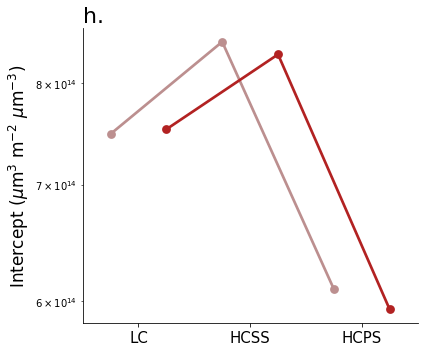

In [28]:

#fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
#ax_n = axs
#sns.pointplot(ax = ax_n, x="biomes", y='intercept_un', hue="experiment", order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5', 'obs'],  palette = palette_experiments,  data=df_mean, errorbar=None, capsize=.1,dodge = 0.5,scale = 1.5)
g=sns.catplot( x="biomes", y='intercept', hue="experiment", order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5'], palette = palette_experiments,  data=df_mean, legend=False, errorbar=None,dodge = 0.5, kind='point')
#g.map(sns.stripplot, x='biomes', y='intercept', hue='experiment', order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5', 'obs'], alpha=.05, palette = palette_experiments,linewidth=0.7, legend=False,  data=df_CMIP6, dodge=True, edgecolor='black')
#sns.stripplot(ax=ax_n, x='biomes', y='intercept_un', hue='experiment', order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5', 'obs'], alpha=.2, legend=False, palette = palette_experiments,linewidth=0.7,  data=df_CMIP6, dodge=True, edgecolor='black')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r'Intercept ($\mu$m$^{3}$ m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
#ax_n.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'observations \n (PSSdb)'], fontsize = 'xx-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.xlabel('')
#plt.ylim(3e14, 5e14)
plt.title('h.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_intercept_avg_experiments_NO_GISS.pdf', dpi=300)



## biovolume

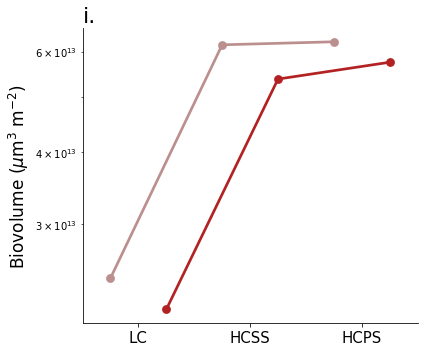

In [29]:

#fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
#ax_n = axs
#sns.pointplot(ax = ax_n, x="biomes", y='total_biovolume', hue="experiment", order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5', 'obs'],  palette = palette_experiments,  data=df_mean, errorbar=None, capsize=.1,dodge = 0.5,scale = 1.5)
#sns.stripplot(ax=ax_n, x='biomes', y='total_biovolume', hue='experiment', order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5', 'obs'], alpha=.2, legend=False, palette = palette_experiments,linewidth=0.7,  data=df_CMIP6, dodge=True, edgecolor='black')
g=sns.catplot( x="biomes", y='total_biovolume', hue="experiment", order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5'], palette = palette_experiments,  data=df_mean, legend=False, errorbar=None,dodge = 0.5, kind='point')
#g.map(sns.stripplot, x='biomes', y='total_biovolume', hue='experiment', order =['LC', 'HCSS', 'HCPS'],hue_order=['hist', 'ssp5', 'obs'], alpha=.05, palette = palette_experiments,linewidth=0.7, legend=False,  data=df_CMIP6, dodge=True, edgecolor='black')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r'Biovolume ($\mu$m$^{3}$ m$^{-2}$)', fontsize = 17)
#plt.ylim(3e13, 2e14)
plt.yscale('log')
plt.xlabel('')
plt.title('i.', loc='left', fontsize = 22)
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
#plt.legend(['historical period \n (1985-2014)', 'SSP5-8.5 \n (2070-2100)', 'Observations \n (PSSdb)'], fontsize = 'xx-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_biovol_global_total_biovolume_avg_experiments_NO_GISS.pdf', dpi=300)

